# Evaluate model performance during high wave events

Event 1:

Day 2020-12-04: 12.33 m

Day 2020-12-05: 12.12 m

Event 2:

Day 2020-12-28: 11.49 m

Day 2020-12-29: 10.69 m


In [363]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model


In [364]:
# Set working directory
os.chdir('C:/Users/filot/OneDrive - University of Strathclyde/Diss')

In [365]:
forecast_steps = 24 # to be changed accordingly every model run

In [366]:
input_steps = 3
run_id = forecast_steps

In [ ]:
# Set working directory
os.chdir('C:/Users/filot/OneDrive - University of Strathclyde/Diss')

In [367]:
model_A = load_model(f'results/model_A/saved_model/{run_id}_model.keras')  # load save model

In [368]:
model_B = load_model(f'results/model_B/saved_model/{run_id}_model.keras')  # load saved model

### STEP 1: Load and preprocess CMEMS wave data

In [369]:
# Process data for period of interest over 6 years
ds = xr.open_dataset("data/part9.nc")

# Extract Hmax
hs = ds['VCMX']  # (time, lat, lon)

# Select the last 17472 time steps
hs_trimmed = hs.sel(time=slice("2020-12-28T00:00:00.00", "2020-12-29T23:00:00.00"))

print(hs_trimmed.shape)
first_time = hs_trimmed['time'].isel(time=0).values
print(f"The first time step is: {first_time}")

#fill nan with zeros for land data
hs_filled = hs_trimmed.fillna(0)

# Normalize using Z-score normalization or standardization.
mean_hs = hs_filled.mean().values
std_hs = hs_filled.std().values
hs_norm = (hs_filled - mean_hs) / std_hs

# Convert to NumPy (transpose to time, lat, lon)
data = hs_norm.transpose('time', 'latitude', 'longitude').values

print(data.shape)

(48, 8, 9)
The first time step is: 2020-12-28T00:00:00.000000000
(48, 8, 9)


### STEP 2: Create sequence-to-one training samples

In [370]:
def create_forecast_at_step_dataset(data, input_steps, forecast_steps, stride=1):
    X, y = [], []
    for t in range(0, len(data) - input_steps - forecast_steps + 1, stride):
        X.append(data[t : t + input_steps])  # 3 past time steps
        y.append(data[t + input_steps + forecast_steps - 1])  # specific future step
    X = np.array(X)[..., np.newaxis]  # Add channel dim
    y = np.array(y)[..., np.newaxis]  # Add channel dim
    return X, y
    
X_test, y_test = create_forecast_at_step_dataset(data, input_steps, forecast_steps)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_test: (22, 3, 8, 9, 1) y_test: (22, 8, 9, 1)


### STEP 3: Split into training and test sets

In [371]:
# Optional: get time axis
filtered_time = hs_trimmed['time'].values
target_times = filtered_time[input_steps + forecast_steps - 1:]
print("Test starts at:", target_times[0])

Test starts at: 2020-12-29T02:00:00.000000000


## Step 4: Evaluating results

### Evaluating model using the test sample

In [372]:
# Predict on entire test set A
y_pred_test_A = model_A.predict(X_test)

# Denormalize
y_pred_test_denorm_A = y_pred_test_A * std_hs + mean_hs
y_test_denorm_A = y_test * std_hs + mean_hs

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step


In [373]:
# Predict on entire test set B
y_pred_test_B = model_B.predict(X_test)

# Denormalize
y_pred_test_denorm_B = y_pred_test_B * std_hs + mean_hs
y_test_denorm_B = y_test * std_hs + mean_hs

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


### Calculate RMSE, SI and R2 near Praia do Norte

In [374]:
# Get grid indices for lat=-9.1, lon=39.6
lat_idx = np.argmin(np.abs(ds.latitude.values - 39.6))
lon_idx = np.argmin(np.abs(ds.longitude.values - (-9.1)))
print(lat_idx, lon_idx)

4 6


In [375]:
# For model A
# Extract true and predicted values for this cell, flatten across samples and time
true_vals_A = y_test_denorm_A[:, lat_idx, lon_idx, 0].flatten()
pred_vals_A = y_pred_test_denorm_A[:, lat_idx, lon_idx, 0].flatten()

# Calculate RMSE
rmse_A = np.sqrt(mean_squared_error(true_vals_A, pred_vals_A))

# SI
mean_obs_point_A = np.mean(true_vals_A)
SI_A = rmse_A / mean_obs_point_A

# R
R_A, _ = pearsonr(true_vals_A, pred_vals_A)

print(f"Model A - Overall RMSE near Praia do Norte ({lat_idx}, {lon_idx}): {rmse_A:.4f}")
print(f"Model A - Overall SI near Praia do Norte ({lat_idx}, {lon_idx}): {SI_A:.4f}")
print(f"Model A - Overall R near Praia do Norte ({lat_idx}, {lon_idx}): {R_A:.4f}")

Model A - Overall RMSE near Praia do Norte (4, 6): 1.2403
Model A - Overall SI near Praia do Norte (4, 6): 0.1329
Model A - Overall R near Praia do Norte (4, 6): 0.8299


In [376]:
#save results in text file
with open(f"results/event_2/metrics_run_{run_id}.txt", "w") as f:
    f.write(f"Model A - Overall RMSE near Praia do Norte: {rmse_A:.4f}\n")
    f.write(f"Model A - Overall SI near Praia do Norte: {SI_A:.4f}\n")     
    f.write(f"Model A - Overall R near Praia do Norte: {R_A:.4f}\n")    

In [377]:
# For model B
# Extract true and predicted values for this cell, flatten across samples and time
true_vals_B = y_test_denorm_B[:, lat_idx, lon_idx, 0].flatten()
pred_vals_B = y_pred_test_denorm_B[:, lat_idx, lon_idx, 0].flatten()

# Calculate RMSE
rmse_B = np.sqrt(mean_squared_error(true_vals_B, pred_vals_B))

# SI
mean_obs_point_B = np.mean(true_vals_B)
SI_B = rmse_B / mean_obs_point_B

# R
R_B, _ = pearsonr(true_vals_B, pred_vals_B)

print(f"Model B - Overall RMSE near Praia do Norte ({lat_idx}, {lon_idx}): {rmse_B:.4f}")
print(f"Model B - Overall SI near Praia do Norte ({lat_idx}, {lon_idx}): {SI_B:.4f}")
print(f"Model B - Overall R near Praia do Norte ({lat_idx}, {lon_idx}): {R_B:.4f}")


Model B - Overall RMSE near Praia do Norte (4, 6): 0.5491
Model B - Overall SI near Praia do Norte (4, 6): 0.0589
Model B - Overall R near Praia do Norte (4, 6): 0.7057


In [378]:
# Save results in text file
with open(f"results/event_2/metrics_run_{run_id}.txt", "a") as f:
    f.write(f"Model B - Overall RMSE near Praia do Norte: {rmse_B:.4f}\n")
    f.write(f"Model B - Overall SI near Praia do Norte: {SI_B:.4f}\n")     
    f.write(f"Model B - Overall R near Praia do Norte: {R_B:.4f}\n")
   

### Create Scatter Plot

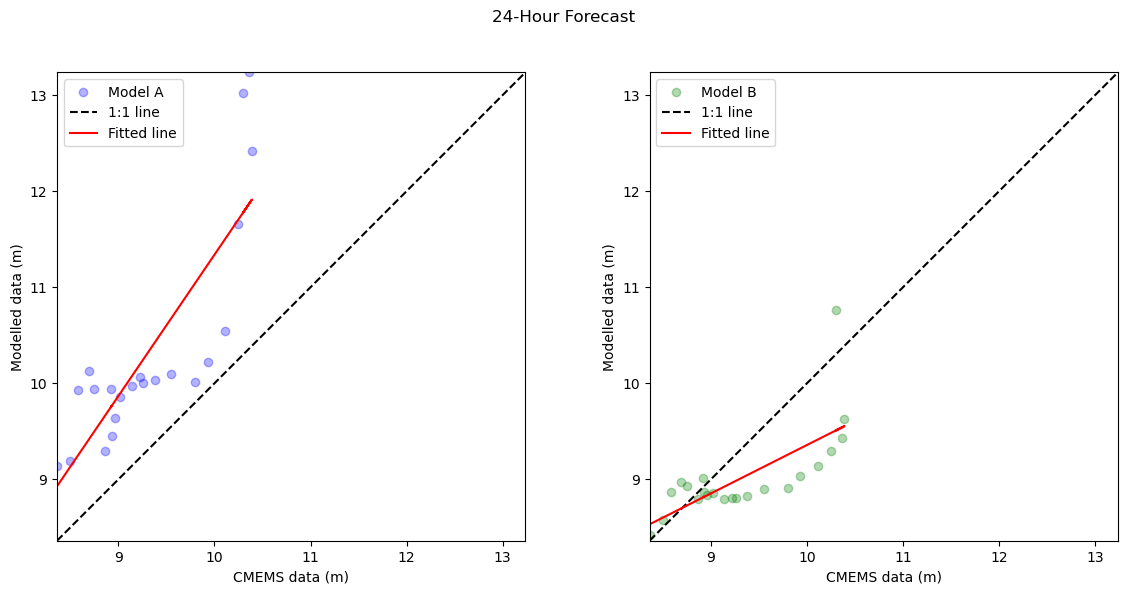

In [379]:
from sklearn.linear_model import LinearRegression

true_vals = true_vals_B  # Use same ground truth for both models

# Fit regression lines
reg_A = LinearRegression().fit(true_vals.reshape(-1, 1), pred_vals_A)
fit_A = reg_A.predict(true_vals.reshape(-1, 1))

reg_B = LinearRegression().fit(true_vals.reshape(-1, 1), pred_vals_B)
fit_B = reg_B.predict(true_vals.reshape(-1, 1))

# Determine common axis limits
min_val = min(true_vals.min(), pred_vals_A.min(), pred_vals_B.min())
max_val = max(true_vals.max(), pred_vals_A.max(), pred_vals_B.max())

# Create subplots without shared axes
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Model A plot
axs[0].scatter(true_vals, pred_vals_A, alpha=0.3, color='blue', label='Model A')
axs[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 line')
axs[0].plot(true_vals, fit_A, color='red', label='Fitted line')
axs[0].set_xlabel('CMEMS data (m)')
axs[0].set_ylabel('Modelled data (m)')
axs[0].set_xlim(min_val, max_val)
axs[0].set_ylim(min_val, max_val)
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend()

# Model B plot
axs[1].scatter(true_vals, pred_vals_B, alpha=0.3, color='green', label='Model B')
axs[1].plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 line')
axs[1].plot(true_vals, fit_B, color='red', label='Fitted line')
axs[1].set_ylabel('Modelled data (m)')
axs[1].set_xlabel('CMEMS data (m)')
axs[1].set_xlim(min_val, max_val)
axs[1].set_ylim(min_val, max_val)
axs[1].set_aspect('equal', adjustable='box')
axs[1].legend()

# Layout
plt.suptitle(f'{run_id}-Hour Forecast')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"results/event_2/scatter_side_by_side_{run_id}.png", dpi=300)
plt.show()
